In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import numpy as np

class InceptionBlk(nn.Module):
    def __init__(self, inch, outch):
        super(InceptionBlk, self).__init__()
        self.b1_conv1 = nn.Conv1d(inch, outch, kernel_size=1)
        self.b1_lrelu = nn.LeakyReLU(negative_slope=0.3)
        
        self.b2_conv1 = nn.Conv1d(inch, outch, kernel_size=1)
        self.b2_lrelu1 = nn.LeakyReLU(negative_slope=0.3)
        self.b2_conv2 = nn.Conv1d(outch, outch, kernel_size=5, padding=2)
        self.b2_lrelu2 = nn.LeakyReLU(negative_slope=0.3)
        
        self.b3_conv1 = nn.Conv1d(inch, outch, kernel_size=1)
        self.b3_lrelu1 = nn.LeakyReLU(negative_slope=0.3)
        self.b3_conv2 = nn.Conv1d(outch, outch, kernel_size=9, padding=4)
        self.b3_lrelu2 = nn.LeakyReLU(negative_slope=0.3)
        
        self.b4_mpool = nn.MaxPool1d(3, stride=1, padding=1)
        self.b4_conv1 = nn.Conv1d(inch, outch, kernel_size=1)
    
    def forward(self, x):
        x1 = self.b1_conv1(x)
        x1 = self.b1_lrelu(x1)

        x2 = self.b2_conv1(x)
        x2 = self.b2_lrelu1(x2)
        x2 = self.b2_conv2(x2)
        x2 = self.b2_lrelu2(x2)

        x3 = self.b3_conv1(x)
        x3 = self.b3_lrelu1(x3)
        x3 = self.b3_conv2(x3)
        x3 = self.b3_lrelu2(x3)

        x4 = self.b4_mpool(x)
        x4 = self.b4_conv1(x4)

        x = torch.cat([x1, x2, x3, x4], dim=1)

        return x

    
class FirstConvBlk(nn.Module):
        def __init__(self, outch, input_shape = [256, 6]):
            
            super(FirstConvBlk, self).__init__()        
            # Shallow feature extraction module
            self.first_conv_blocks = nn.ModuleList([
                nn.Sequential(
                    nn.Conv1d(1, outch, kernel_size=9, padding=4),
                    nn.LeakyReLU(negative_slope=0.3),
                    nn.MaxPool1d(4),
                    # nn.Dropout(0.2)
                ) for _ in range(input_shape[1])
                ])
        def forward(self, x):
            first_conv_outs = []
            for i in range(x.shape[1]):
                x_input = x[:, i:i+1, :]  # Slice operation
                out = self.first_conv_blocks[i](x_input)
                first_conv_outs.append(out)
        
            x = torch.cat(first_conv_outs, dim=1)
            return x

class TransformerTimeSeries(nn.Module):
    """
    基于 Transformer 的时序预测模型。
    模型结构包括：输入嵌入层 -> Transformer 模块（Encoder-Decoder 结构） -> 全连接输出层。
    
    参数：
    input_dim  : 输入特征维度（本例为1）
    model_dim  : Transformer 模型的隐藏层维度
    num_heads  : 注意力头数
    num_layers : Transformer 层数（Encoder 和 Decoder 均采用相同层数）
    dropout    : dropout 概率，用于防止过拟合
    """
    def __init__(self, input_dim=1, model_dim=32, num_heads=4, num_layers=2, dropout=0.1, output_channel=64):
        super(TransformerTimeSeries, self).__init__()
        # 输入嵌入层，将一维输入映射到 model_dim 维度
        self.embedding = nn.Linear(input_dim, model_dim)
        # 构造 Transformer 模块，采用 nn.Transformer 内置实现，Encoder 和 Decoder 均采用相同输入（自编码器方式）
        self.transformer = nn.Transformer(d_model=model_dim,
                                          nhead=num_heads,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          dropout=dropout,batch_first=True)
        # 输出全连接层，将 Transformer 输出映射回一维预测值
        self.fc_out = nn.Linear(model_dim, output_channel)
        
    def forward(self, x):
        """
        前向传播函数。
        参数：
        x: 输入张量，形状为 (batch_size, seq_length, input_dim)
        
        返回：
        输出张量，形状为 (batch_size, seq_length, 1)
        """
        # 将输入数据经过嵌入层映射到高维空间
        x = self.embedding(x)
        # Transformer 模型要求的输入形状为 (seq_length, batch_size, model_dim)，因此进行转置
        # x = x.permute(1, 0, 2)
        # 这里使用自注意力机制，Encoder 和 Decoder 均输入相同数据
        x = self.transformer(x, x)
        # 将 Transformer 输出映射为目标维度
        x = self.fc_out(x)
        # 恢复原始形状 (batch_size, seq_length, 1)
        # x = x.permute(1, 0, 2)
        return x

class TransformerPredictor(nn.Module):
    def __init__(self, input_dim=48, d_model=64, nhead=8, num_layers=1, dropout=0.0, pre_num=3):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)  # 输入特征映射
        self.pos_encoder = PositionalEncoding(d_model, dropout)  # 位置编码
        # Transformer编码器层（含因果掩码，避免未来信息泄露）
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=256, dropout=dropout, batch_first=True,
            norm_first=True  # 先归一化，再残差连接，提升稳定性
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, enable_nested_tensor=False)
        self.fc = nn.Linear(d_model, pre_num)  # 输出层
        
    def forward(self, x):
        # 输入形状：(batch_size, seq_length, input_dim)
        x = self.embedding(x) * np.sqrt(self.d_model)  # 缩放嵌入，稳定梯度
        x = self.pos_encoder(x)  # 注入位置信息
        # 因果掩码：确保第i步只能看到前i步的信息
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=x.device), diagonal=1)
        x = self.transformer_encoder(x, src_key_padding_mask=None, mask=mask)
        output = self.fc(x)  # 输出形状：(batch_size, seq_length, 1)
        return output
 
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        # self.dropout = nn.Dropout(p=dropout)
        # 预计算位置编码，避免重复计算
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x形状：(batch_size, seq_length, d_model)
        x = x + self.pe[:x.size(1), :]  # 叠加位置编码
        # x = self.dropout(x)
        return x

class SATNet(nn.Module):
    def __init__(self, PreNum=3, PreLen=1, input_shape = [256, 6]):
        super(SATNet, self).__init__()
        self.scale = 48
        firstFilter = 8
        inceptionFilter = input_shape[1] * firstFilter
        self.FirConv = FirstConvBlk(outch=firstFilter, input_shape=input_shape)
        self.InceptionBlk1 = InceptionBlk(inch=inceptionFilter, outch=int(inceptionFilter/4))
        self.lrelu1 = nn.LeakyReLU(negative_slope=0.3)

        self.transformer = TransformerTimeSeries(inceptionFilter, model_dim=64, dropout=0.001, output_channel=3)
        

    def forward(self, x):
        x = self.FirConv(x)
        x = self.InceptionBlk1(x)
        x = self.lrelu1(x)
        # x = self.conv1(x)
        # x = self.relu1(x)
        x = x.permute(0, 2, 1)
        x = self.transformer(x)
        # x,_ = self.gru1(x)
        # x,_ = self.gru2(x)
        x = x[:, -1, :]
        # x = self.l1(x)
        # x = self.relu1(x)
        # x = self.l2(x)

        return x
    
if __name__ == '__main__':
    model = SATNet(PreNum=3)
    model = model.cuda()
    inputs = torch.randn(24, 6, 256)
    inputs = inputs.cuda()
    outputs = model(inputs)
    print("outpus's shape :", outputs.shape)


outpus's shape : torch.Size([24, 3])


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
from datetime import datetime
from utils.tools import make_datasets,make_dir
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# 数据加载
data_Dir = "/home/admin123/SATData/data"
# 实例化数据集
emg_data, angle_data, _ = make_datasets(data_Dir, peopleList=['S01'], exp_class="MJ", cluster_num=6, fusionMethod="PCA", windowLength=256, stepLength=1, delta_T=20)

semgData = torch.tensor(emg_data, dtype=torch.float32)
angleData = torch.tensor(angle_data, dtype=torch.float32)
print("semg 数据形状为：", semgData.shape)
print("angle 数据形状为：", angleData.shape)

dataset = TensorDataset(semgData, angleData)

# 定义划分比例
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
# 数据集分割
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 初始化模型、优化器和损失函数
modelName = "SAT"
model = SATNet(PreNum=3)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
criterion = criterion.cuda()
# scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=0)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
checkpoint_save_Dir = os.path.join("/home/admin123/SATData", "Run", modelName, formatted_time)
make_dir(checkpoint_save_Dir)
checkpoint_save_path = os.path.join(checkpoint_save_Dir,"best.pth")

best_loss = float('inf')
train_running_loss_ls = []
test_running_loss_ls = []
for epoch in range(1, 2001):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("learning rate=", optimizer.param_groups[0]['lr'])
    scheduler.step()
    train_running_loss_ls.append(running_loss)
    
    # 测试模型
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_running_loss_ls.append(test_loss)

    # if epoch % 50 == 0:

    print('Epoch %d, Train Loss: %.5f, Test Loss: %.5f'%(epoch, running_loss, test_loss*train_size/test_size))

    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(model.state_dict(), checkpoint_save_path)
        # print("model update")s

semg 数据形状为： torch.Size([26645, 6, 256])
angle 数据形状为： torch.Size([26645, 3])
learning rate= 0.001
Epoch 1, Train Loss: 311751.42188, Test Loss: 279664.48926
learning rate= 0.001
Epoch 2, Train Loss: 242222.17700, Test Loss: 203696.29297


KeyboardInterrupt: 

loss 文件已保存到: /home/admin123/SATData/Run/SAT/04-13-19:44:58/output.csv


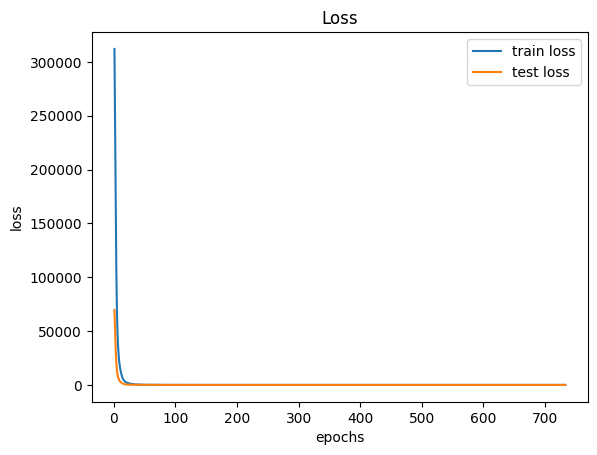

In [4]:
import csv
# 计算性能指标
import matplotlib.pyplot as plt
from Models.SATNet import SATNet
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

file_path = os.path.join(checkpoint_save_Dir, "output.csv")
# 将两个列表写入到 CSV 文件
with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    
    # 写入表头（可选）
    writer.writerow(["train_loss", "test_loss"])
    
    # 写入数据
    for item1, item2 in zip(train_running_loss_ls, test_running_loss_ls):
        writer.writerow([item1, item2])
print(f"loss 文件已保存到: {file_path}")

# 绘制 loss 曲线
plt.figure()
plt.plot(np.arange(len(train_running_loss_ls))+1, train_running_loss_ls, label="train loss")
plt.plot(np.arange(len(test_running_loss_ls))+1, test_running_loss_ls, label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()
plt.savefig(os.path.join(checkpoint_save_Dir, "loss.png"), dpi=300, bbox_inches='tight')


metrics 文件已保存到: /home/admin123/SATData/Run/SAT/04-13-17:24:33/metrics.csv


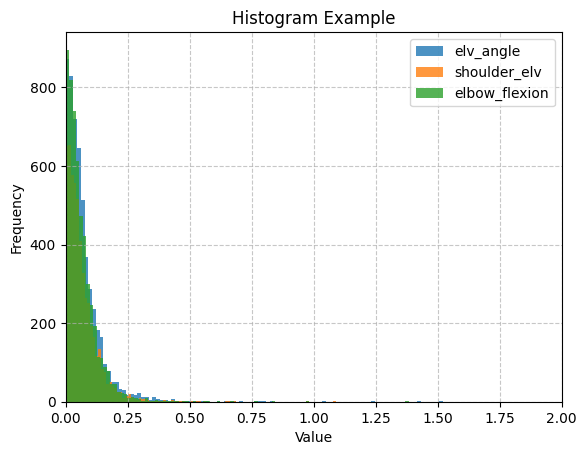

In [ ]:

# 初始化模型结构
model_eval = SATNet().cuda()
model_eval.load_state_dict(torch.load(checkpoint_save_path))

model_eval = model
model_eval.eval()
truthAnglesList = []
preAnglesList = []
for inputs, labels in test_loader:
    truthAnglesList.append(labels)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model_eval(inputs)
    preAnglesList.append(outputs.cpu().detach().numpy())

truthAngles = np.concatenate(truthAnglesList, axis=0)
preAngles = np.concatenate(preAnglesList, axis=0)

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(np.abs(tru_angle_1-pre_angle_1), bins=100, alpha=0.8, label="elv_angle")
plt.hist(np.abs(tru_angle_2-pre_angle_2), bins=100, alpha=0.8, label="shoulder_elv")
plt.hist(np.abs(tru_angle_3-pre_angle_3), bins=100, alpha=0.8, label="elbow_flexion")
plt.xlim((0, 2))
plt.legend()
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(checkpoint_save_Dir, "test_error.png"), dpi=300, bbox_inches='tight')

rmse, mae, r2 = [], [], []
rmse.append(np.sqrt(mean_squared_error(tru_angle_1, pre_angle_1)))
rmse.append(np.sqrt(mean_squared_error(tru_angle_2, pre_angle_2)))
rmse.append(np.sqrt(mean_squared_error(tru_angle_3, pre_angle_3)))

mae.append(mean_absolute_error(tru_angle_1, pre_angle_1))
mae.append(mean_absolute_error(tru_angle_2, pre_angle_2))
mae.append(mean_absolute_error(tru_angle_2, pre_angle_2))

r2.append(r2_score(tru_angle_1, pre_angle_1))
r2.append(r2_score(tru_angle_2, pre_angle_2))
r2.append(r2_score(tru_angle_2, pre_angle_2))

file_path = os.path.join(checkpoint_save_Dir, "metrics.csv")
# 将两个列表写入到 CSV 文件
with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    
    # 写入表头（可选）
    writer.writerow(["rmse", "mae", "R2_score"])
    
    # 写入数据
    for item1, item2, item3 in zip(rmse, mae, r2):
        writer.writerow([item1, item2, item3])
print(f"metrics 文件已保存到: {file_path}")



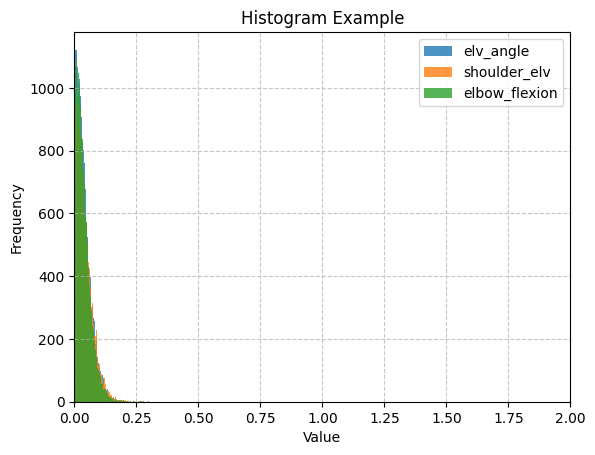

In [ ]:
model_eval.eval()
truthAnglesList = []
preAnglesList = []
for inputs, labels in train_loader:
    truthAnglesList.append(labels)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model_eval(inputs)
    preAnglesList.append(outputs.cpu().detach().numpy())

truthAngles = np.concatenate(truthAnglesList, axis=0)
preAngles = np.concatenate(preAnglesList, axis=0)

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(np.abs(tru_angle_1-pre_angle_1), bins=100, alpha=0.8, label="elv_angle")
plt.hist(np.abs(tru_angle_2-pre_angle_2), bins=100, alpha=0.8, label="shoulder_elv")
plt.hist(np.abs(tru_angle_3-pre_angle_3), bins=100, alpha=0.8, label="elbow_flexion")
plt.xlim((0, 2))
plt.legend()
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(checkpoint_save_Dir, "train_error.png"), dpi=300, bbox_inches='tight')